In [12]:
import pandas as pd
import numpy as np

with open('../data_csv/FinalDfThina.csv', 'rb') as f:
    df_T = pd.read_csv(f)
df_T['monkey'] = 'T'

with open('../data_csv/FinalDfNana.csv', 'rb') as f:
    df_N = pd.read_csv(f)
df_N['monkey'] = 'N'

In [ ]:
def recenter_trajectory_3d(group):
    initial_x_offset = group['x'].iloc[0]
    initial_y_offset = group['y'].iloc[0]
    initial_z_offset = group['z'].iloc[0]
    group['centered_x'] = group['x'] - initial_x_offset
    group['centered_y'] = group['y'] - initial_y_offset
    group['centered_z'] = group['z'] - initial_z_offset
    return group

df_N = df_N.groupby('id').apply(recenter_trajectory_3d)
df_N.reset_index(drop=True, inplace=True)

df_T = df_T.groupby('id').apply(recenter_trajectory_3d)
df_T.reset_index(drop=True, inplace=True)

In [14]:
def compute_touchpoints_monkey(df_m, N):
    rows = []
    d = df_m[df_m['id_update'].isna()]
    req = {'centered_x','centered_y','centered_z','end_time','time_milisecond','id','id_target'}
    missing = req - set(d.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    for target, g in d.groupby('id_target'):
        pts = []
        for tid, gg in g.groupby('id'):
            end_t = gg['end_time'].iloc[0]
            after = gg[gg['time_milisecond'] >= end_t].dropna(subset=['centered_x','centered_y','centered_z']).head(N)
            if after.empty: 
                continue
            pts.append(after[['centered_x','centered_y','centered_z']].median().values)
        if pts:
            p = np.median(np.vstack(pts), axis=0)
            rows.append({'target': int(target), 'x': p[0], 'y': p[1], 'z': p[2]})
    return pd.DataFrame(rows).sort_values('target')

touch_T = compute_touchpoints_monkey(df_T, N=10)
touch_N = compute_touchpoints_monkey(df_N, N=10)

print("\nThina touchpoints (first rows):")
print(touch_T.head(20))
print("\nNana touchpoints (first rows):")
print(touch_N.head(20))



Thina touchpoints (first rows):
   target         x         y         z
0       1 -0.085836  2.623904  1.559537
1       2 -1.069675  2.909125 -0.213900
2       3 -1.809395  1.726269 -2.359253
3       4 -1.256432 -0.208390 -2.405873
4       5 -0.213019 -1.391136 -1.184071
5       6  0.815527 -2.037153  0.471711
6       7  1.559920 -1.594215  2.286146
7       8  1.396673  0.608384  3.192988

Nana touchpoints (first rows):
   target         x         y         z
0       1  2.287681  0.572157  0.028885
1       2  2.164924  0.094948 -2.424826
2       3  0.494292 -0.429393 -3.021393
3       4 -0.397970 -0.082907 -1.708659
4       5 -0.905612  0.060655 -0.275132
5       6 -0.837593  0.317729  1.020322
6       7 -0.266673  0.378622  2.013210
7       8  1.997738  0.650480  0.944151


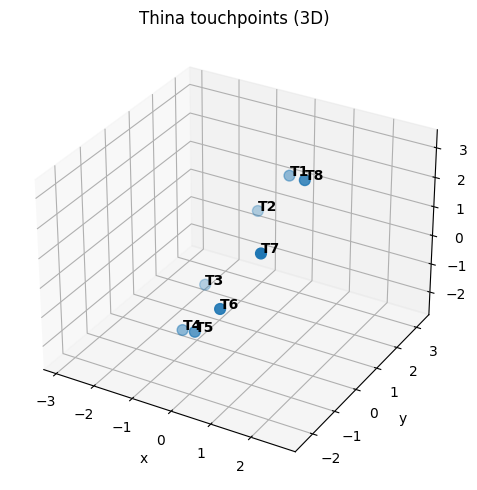

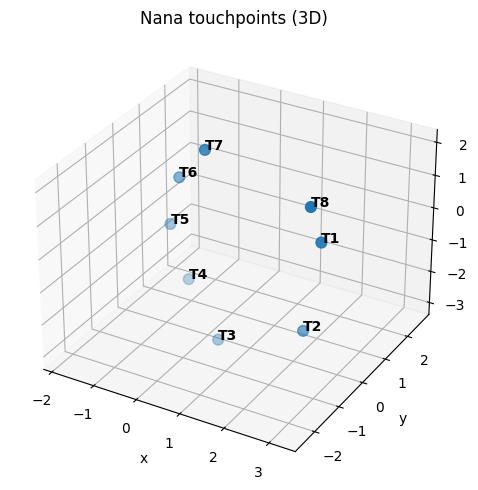

In [15]:
import matplotlib.pyplot as plt
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d(); y_limits = ax.get_ylim3d(); z_limits = ax.get_zlim3d()
    x_range = x_limits[1]-x_limits[0]; y_range = y_limits[1]-y_limits[0]; z_range = z_limits[1]-z_limits[0]
    max_range = max([x_range,y_range,z_range]) / 2.0
    x_mid = np.mean(x_limits); y_mid = np.mean(y_limits); z_mid = np.mean(z_limits)
    ax.set_xlim3d([x_mid-max_range, x_mid+max_range])
    ax.set_ylim3d([y_mid-max_range, y_mid+max_range])
    ax.set_zlim3d([z_mid-max_range, z_mid+max_range])

def plot_touch_3d(touch_df, title):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(touch_df['x'], touch_df['y'], touch_df['z'], s=60, c='tab:blue')
    for _, r in touch_df.iterrows():
        ax.text(r['x'], r['y'], r['z'], f"T{int(r['target'])}", fontsize=10, weight='bold')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.set_title(title)
    set_axes_equal(ax)
    plt.tight_layout(); plt.show()

plot_touch_3d(touch_T, "Thina touchpoints (3D)")
plot_touch_3d(touch_N, "Nana touchpoints (3D)")


In [ ]:
def center_and_vectors(touch_df, targets_order=None):
    t = touch_df.set_index('target')
    if targets_order is None:
        targets_order = sorted(t.index.tolist())
    targets_order = [tg for tg in targets_order if tg in t.index]
    P = t.loc[targets_order, ['x','y','z']].to_numpy()
    center = np.median(P, axis=0)
    vecs = {tg: (t.loc[tg, ['x','y','z']].to_numpy() - center) for tg in targets_order}
    for tg in vecs:
        norm = np.linalg.norm(vecs[tg])
        if norm > 0:
            vecs[tg] /= norm
    return targets_order, center, vecs

targets_order = [1,2,3,4,5,6,7,8]

avail_T, center_T, vecs_T = center_and_vectors(touch_T, targets_order)
avail_N, center_N, vecs_N = center_and_vectors(touch_N, targets_order)

print("\nThina center:", center_T)
print("Nana  center:", center_N)
print("Common targets:", [tg for tg in targets_order if tg in avail_T and tg in avail_N])

print("\nThina centered target vectors:")
for tg in avail_T: print(f"T{tg}:", vecs_T[tg])
print("\nNana centered target vectors:")
for tg in avail_N: print(f"T{tg}:", vecs_N[tg])

common = [tg for tg in targets_order if tg in avail_T and tg in avail_N]
A = np.vstack([vecs_T[tg] for tg in common])
B = np.vstack([vecs_N[tg] for tg in common])

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A[:,0], A[:,1], A[:,2], c='tab:blue', s=70)
ax.scatter(B[:,0], B[:,1], B[:,2], c='tab:orange', s=70)
for i, tg in enumerate(common):
    ax.text(B[i,0], B[i,1], B[i,2], f"T{tg}", color='tab:orange', fontsize=10, weight='bold')
    ax.text(A[i,0], A[i,1], A[i,2], f"T{tg}", color='tab:blue', fontsize=10, weight='bold')
ax.set_title("Centered targets – before alignment")
ax.set_xlabel('dx'); ax.set_ylabel('dy'); ax.set_zlabel('dz')
set_axes_equal(ax); ax.legend(); plt.tight_layout(); plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(A[:,0], A[:,1], c='tab:blue', s=70, label='Thina')
ax.scatter(B[:,0], B[:,1], c='tab:orange', s=70, label='Nana')
for i, tg in enumerate(common):
    ax.text(B[i,0], B[i,1], f"T{tg}", color='tab:orange', fontsize=10, weight='bold')
    ax.text(A[i,0], A[i,1], f"T{tg}", color='tab:blue', fontsize=10, weight='bold')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.legend()
plt.tight_layout()
plt.show()


Rotation matrix R:
[[ 0.1058637  -0.75608665  0.64585281]
 [ 0.88145963 -0.22926343 -0.41287673]
 [ 0.46024101  0.61300184  0.64218919]]
det(R) = 0.999999999999999
Singular values: [4.23403984e+00 3.58556330e+00 7.32608092e-04]
RMSD before: 1.1226624309346187
RMSD after : 0.2127965397096058


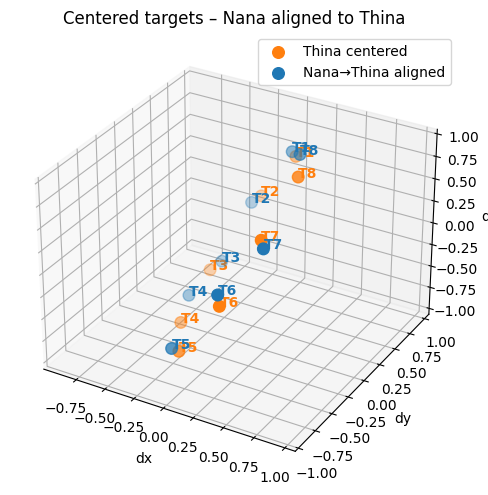

In [ ]:
def rmsd(A, B):
    return np.sqrt(np.mean(np.sum((A - B) ** 2, axis=1)))

def kabsch_rotation(A, B, proper=True):
    H = A.T @ B
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if proper and np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    return R, S

# Nana → Thina
R, S = kabsch_rotation(B, A, proper=True)
B_map = (R @ B.T).T


print("\nRotation matrix R:")
print(R)
print("det(R) =", np.linalg.det(R))
print("Singular values:", S)
print("RMSD before:", rmsd(B, A))
print("RMSD after :", rmsd(B_map, A))


fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A[:,0], A[:,1], A[:,2], c='tab:orange', s=70, label='Thina centered')
ax.scatter(B_map[:,0], B_map[:,1], B_map[:,2], c='tab:blue', s=70, label='Nana→Thina aligned')
for i, tg in enumerate(common):
    ax.text(A[i,0], A[i,1], A[i,2], f"T{tg}", color='tab:orange', fontsize=10, weight='bold')
    ax.text(B_map[i,0], B_map[i,1], B_map[i,2], f"T{tg}", color='tab:blue', fontsize=10, weight='bold')
ax.set_title("Centered targets – Nana aligned to Thina")
ax.set_xlabel('dx'); ax.set_ylabel('dy'); ax.set_zlabel('dz')
set_axes_equal(ax); ax.legend(); plt.tight_layout(); plt.show()

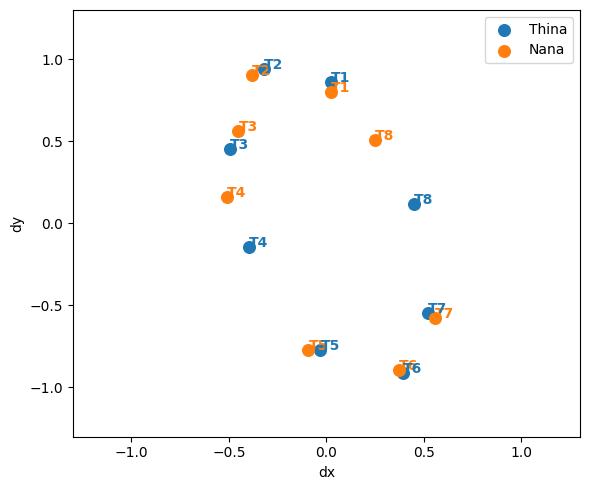

In [23]:
# 2D overlay before alignment (centered)
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(A[:,0], A[:,1], c='tab:blue', s=70, label='Thina')
ax.scatter(B_map[:,0], B_map[:,1], c='tab:orange', s=70, label='Nana')
for i, tg in enumerate(common):
    ax.text(B_map[i,0], B_map[i,1], f"T{tg}", color='tab:orange', fontsize=10, weight='bold')
    ax.text(A[i,0], A[i,1], f"T{tg}", color='tab:blue', fontsize=10, weight='bold')
ax.set_xlabel('dx')
ax.set_ylabel('dy')
ax.set_xlim([-1.3, 1.3])
ax.set_ylim([-1.3, 1.3])
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
def apply_transform_df(df_m, center_src, center_dst, R):
    P = df_m[['centered_x','centered_y','centered_z']].to_numpy()
    Pm = (R @ (P - center_src).T).T + center_dst
    out = df_m.copy()
    out[['x_aligned','y_aligned','z_aligned']] = Pm
    return out

df_T_aligned = df_T.copy()
df_T_aligned[['x_aligned','y_aligned','z_aligned']] = df_T_aligned[['centered_x','centered_y','centered_z']].to_numpy()

df_N_aligned = apply_transform_df(df_N, center_N, center_T, R.T)

print("\nAligned Thina sample (first rows):")
print(df_T_aligned[['x_aligned','y_aligned','z_aligned']].head())
print("\nNana sample (first rows):")
print(df_N_aligned[['x_aligned','y_aligned','z_aligned']].head())



Aligned Thina sample (first rows):
   x_aligned  y_aligned  z_aligned
0   0.000000   0.000000   0.000000
1  -0.000218   0.000373  -0.000788
2  -0.000547   0.000845  -0.001805
3  -0.000954   0.001404  -0.002965
4  -0.001335   0.002027  -0.004117

Nana sample (first rows):
   x_aligned  y_aligned  z_aligned
0  -0.286688   0.408827   0.219662
1  -0.286474   0.408440   0.219656
2  -0.286159   0.407883   0.219707
3  -0.285704   0.407161   0.219890
4  -0.285091   0.406306   0.220267


In [31]:
import numpy as np
import pandas as pd

def promote_aligned_xyz(df):
    cols = ['x_aligned','y_aligned','z_aligned']
    if all(c in df.columns for c in cols):
        for a,b in zip(['x','y','z'], cols):
            if a in df.columns:
                df[a+'_orig'] = df[a]
            df[a] = df[b]
    return df

df_Ta = promote_aligned_xyz(df_T_aligned.copy())
df_Na = promote_aligned_xyz(df_N_aligned.copy())

with open('../data_csv/FinalDfThina_aligned.csv', 'wb') as f:
    df_Ta.to_csv(f, index=False)
with open('../data_csv/FinalDfNana_aligned.csv', 'wb') as f:
    df_Na.to_csv(f, index=False)